In [1]:
import os, glob
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import scvi

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def standardize_one_minimal(adata,species = "human",use_ensembl=False):
    if 'gene_symbol_raw' not in adata.var.columns:
        adata.var['gene_symbol_raw'] = adata.var_names.astype(str)
    has_ens_col = "gene_ids" in adata.var.columns
    if use_ensembl and has_ens_col:
        ens = adata.var["gene_ids"].astype(str).str.replace(r"\.\d+$", "", regex=True)
        adata.var_names = ens.values
        adata.var["gene_symbol"] = (
        adata.var["gene_symbol_raw"].astype(str).replace(r"\.\d+$", "",regex=True)
        )
    else:
        adata.var_names = adata.var_names.astype(str).str.replace(r"\.\d+$", "", regex=True)
        adata.var["gene_symbol"] = adata.var_names.astype(str)
        
    adata.var_names_make_unique()
    gs_upper = adata.var["gene_symbol"].astype(str).str.upper()
    adata.var["mt"] = gs_upper.str.startswith("MT-")
    return adata
    

# per-sample QC

In [3]:
def qc_one_sample(adata,min_genes = 200, max_genes = 2500,min_counts = 500,max_pct_mt = 20):
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'],percent_top = None,inplace=True)
    thr = max_pct_mt * 100 if max_pct_mt <= 1 else max_pct_mt
    keep = (
        (adata.obs["n_genes_by_counts"] >= min_genes) & 
        (adata.obs["n_genes_by_counts"]<= max_genes) &
        (adata.obs["total_counts"] >= min_counts) & 
        (adata.obs["pct_counts_mt"] <= thr) 
    )

    adata = adata[keep].copy()
    if "counts" not in adata.layers:
        adata.layers["counts"] = adata.X.copy()
    return adata

In [4]:
try:
    _ = adata_all
except NameError:
    base_dir = '/home/qian@vitra.bio/ava/data/GSE118127'
    patterns = ["**/*filtered_gene_bc_matrices_h5.h5","*filtered_gene_bc_matrices_h5.h5"]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir,pat),recursive=True))
    files = sorted(set(files))
    assert len(files)>0, f"there is no 10x h5 in {base_dir}. Please check file path or file patterns."
    adatas = []
    for fp in files:
        ad = sc.read_10x_h5(fp)
        sample_name = os.path.basename(fp).replace("_filtered_gene_bc_matrices_h5.h5","")
        ad = standardize_one_minimal(ad,species = "human", use_ensembl = False)
        ad.obs["sample"] = sample_name
        
        raw_shape = ad.shape
        print(f"[{sample_name}] raw shape: cells={raw_shape[0]},genes = {raw_shape[1]}")
        
        ad = qc_one_sample(ad, min_genes=200, min_counts=500, max_pct_mt=20)
        
        qc_shape = ad.shape
        kept_ratio = qc_shape[0] / raw_shape[0] if raw_shape[0] > 0 else 0
        print(f"[{sample_name}] post-QC shape: cells={qc_shape[0]}"
             f"({kept_ratio:.1%} kept),genes = {qc_shape[1]}")
        
        adatas.append(ad)
    
    adata_all = sc.concat(adatas,axis  = 0,join = "outer")
    if "counts" not in adata_all.layers:
        adata_all.layers["counts"] = adata_all.X.copy()
    print(adata_all.shape)
    print(adata_all.obs["sample"].value_counts())

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319032_sample_1-1] raw shape: cells=5448,genes = 33694
[GSM3319032_sample_1-1] post-QC shape: cells=5442(99.9% kept),genes = 33694
[GSM3319033_sample_1-2] raw shape: cells=1713,genes = 33694
[GSM3319033_sample_1-2] post-QC shape: cells=1695(98.9% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319034_sample_1-3] raw shape: cells=3604,genes = 33694
[GSM3319034_sample_1-3] post-QC shape: cells=3593(99.7% kept),genes = 33694
[GSM3319035_sample_1-4] raw shape: cells=2954,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319035_sample_1-4] post-QC shape: cells=2912(98.6% kept),genes = 33694
[GSM3319036_sample_1-5] raw shape: cells=2566,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319036_sample_1-5] post-QC shape: cells=2389(93.1% kept),genes = 33694
[GSM3319037_sample_1-6] raw shape: cells=2091,genes = 33694
[GSM3319037_sample_1-6] post-QC shape: cells=2074(99.2% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319038_sample_1-7] raw shape: cells=4357,genes = 33694
[GSM3319038_sample_1-7] post-QC shape: cells=4353(99.9% kept),genes = 33694
[GSM3319039_sample_1-8] raw shape: cells=2703,genes = 33694
[GSM3319039_sample_1-8] post-QC shape: cells=2628(97.2% kept),genes = 33694
[GSM3319040_sample_3-13] raw shape: cells=515,genes = 33694
[GSM3319040_sample_3-13] post-QC shape: cells=505(98.1% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319041_sample_3-14] raw shape: cells=1287,genes = 33694
[GSM3319041_sample_3-14] post-QC shape: cells=1273(98.9% kept),genes = 33694
[GSM3319042_sample_3-15] raw shape: cells=820,genes = 33694
[GSM3319042_sample_3-15] post-QC shape: cells=735(89.6% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319043_sample_3-16] raw shape: cells=5135,genes = 33694
[GSM3319043_sample_3-16] post-QC shape: cells=4658(90.7% kept),genes = 33694
[GSM3319044_sample_3-17] raw shape: cells=4541,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319044_sample_3-17] post-QC shape: cells=3857(84.9% kept),genes = 33694
[GSM3319045_sample_3-18] raw shape: cells=5963,genes = 33694
[GSM3319045_sample_3-18] post-QC shape: cells=4678(78.5% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3319046_sample_3-5] raw shape: cells=563,genes = 33694
[GSM3319046_sample_3-5] post-QC shape: cells=485(86.1% kept),genes = 33694
[GSM3319047_sample_3-6] raw shape: cells=166,genes = 33694
[GSM3319047_sample_3-6] post-QC shape: cells=89(53.6% kept),genes = 33694
[GSM3557959_sample1_B1_i12A] raw shape: cells=881,genes = 33694
[GSM3557959_sample1_B1_i12A] post-QC shape: cells=759(86.2% kept),genes = 33694
[GSM3557960_sample10_B2_i10D] raw shape: cells=512,genes = 33694
[GSM3557960_sample10_B2_i10D] post-QC shape: cells=329(64.3% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557961_sample11_B2_i10F] raw shape: cells=1226,genes = 33694
[GSM3557961_sample11_B2_i10F] post-QC shape: cells=1104(90.0% kept),genes = 33694
[GSM3557962_sample12_B2_i10G] raw shape: cells=845,genes = 33694
[GSM3557962_sample12_B2_i10G] post-QC shape: cells=757(89.6% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557963_sample13_B1_i12C] raw shape: cells=435,genes = 33694
[GSM3557963_sample13_B1_i12C] post-QC shape: cells=427(98.2% kept),genes = 33694
[GSM3557964_sample145_B1_i12D] raw shape: cells=1186,genes = 33694
[GSM3557964_sample145_B1_i12D] post-QC shape: cells=1160(97.8% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557965_sample2_B1_i12B] raw shape: cells=739,genes = 33694
[GSM3557965_sample2_B1_i12B] post-QC shape: cells=715(96.8% kept),genes = 33694
[GSM3557966_sample3_B1_i12G] raw shape: cells=108,genes = 33694
[GSM3557966_sample3_B1_i12G] post-QC shape: cells=96(88.9% kept),genes = 33694
[GSM3557967_sample4_B1_i12F] raw shape: cells=555,genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557967_sample4_B1_i12F] post-QC shape: cells=348(62.7% kept),genes = 33694
[GSM3557968_sample5_B2_i10E] raw shape: cells=492,genes = 33694
[GSM3557968_sample5_B2_i10E] post-QC shape: cells=450(91.5% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557969_sample6a_B1_i12H] raw shape: cells=2549,genes = 33694
[GSM3557969_sample6a_B1_i12H] post-QC shape: cells=2514(98.6% kept),genes = 33694
[GSM3557970_sample7_B2_i10C] raw shape: cells=722,genes = 33694
[GSM3557970_sample7_B2_i10C] post-QC shape: cells=610(84.5% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557971_sample8a_B2_i10A] raw shape: cells=529,genes = 33694
[GSM3557971_sample8a_B2_i10A] post-QC shape: cells=446(84.3% kept),genes = 33694
[GSM3557972_sample8b_B2_i10B] raw shape: cells=760,genes = 33694
[GSM3557972_sample8b_B2_i10B] post-QC shape: cells=696(91.6% kept),genes = 33694


/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[GSM3557973_sampleC1_B1_i12E] raw shape: cells=241,genes = 33694
[GSM3557973_sampleC1_B1_i12E] post-QC shape: cells=159(66.0% kept),genes = 33694
(51936, 33694)
sample
GSM3319032_sample_1-1           5442
GSM3319045_sample_3-18          4678
GSM3319043_sample_3-16          4658
GSM3319038_sample_1-7           4353
GSM3319044_sample_3-17          3857
GSM3319034_sample_1-3           3593
GSM3319035_sample_1-4           2912
GSM3319039_sample_1-8           2628
GSM3557969_sample6a_B1_i12H     2514
GSM3319036_sample_1-5           2389
GSM3319037_sample_1-6           2074
GSM3319033_sample_1-2           1695
GSM3319041_sample_3-14          1273
GSM3557964_sample145_B1_i12D    1160
GSM3557961_sample11_B2_i10F     1104
GSM3557959_sample1_B1_i12A       759
GSM3557962_sample12_B2_i10G      757
GSM3319042_sample_3-15           735
GSM3557965_sample2_B1_i12B       715
GSM3557972_sample8b_B2_i10B      696
GSM3557970_sample7_B2_i10C       610
GSM3319040_sample_3-13           505
GSM3319046_sample_

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata_all.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCTGAGACGCTTT-1,GSM3319032_sample_1-1,937,6.843750,3230.0,8.080547,79.0,4.382027,2.445820
AAACCTGAGGCTAGGT-1,GSM3319032_sample_1-1,547,6.306275,1545.0,7.343426,20.0,3.044523,1.294498
AAACCTGCAAGTCTGT-1,GSM3319032_sample_1-1,1130,7.030857,2932.0,7.983781,82.0,4.418840,2.796726
AAACCTGCAGCTTAAC-1,GSM3319032_sample_1-1,845,6.740519,1673.0,7.422971,29.0,3.401197,1.733413
AAACCTGCATTCACTT-1,GSM3319032_sample_1-1,585,6.373320,1363.0,7.218177,66.0,4.204693,4.842260
...,...,...,...,...,...,...,...,...
TTCGAAGGTATGCTTG-1,GSM3557973_sampleC1_B1_i12E,689,6.536692,1045.0,6.952729,83.0,4.430817,7.942584
TTGACTTCATAGGATA-1,GSM3557973_sampleC1_B1_i12E,854,6.751101,1358.0,7.214504,69.0,4.248495,5.081001
TTGCGTCCAACAACCT-1,GSM3557973_sampleC1_B1_i12E,2479,7.816014,7093.0,8.867004,173.0,5.159055,2.439024
TTGGAACTCGGCTACG-1,GSM3557973_sampleC1_B1_i12E,1576,7.363280,3594.0,8.187300,116.0,4.762174,3.227602


In [6]:
print(adata_all.obs["sample"].unique())

['GSM3319032_sample_1-1' 'GSM3319033_sample_1-2' 'GSM3319034_sample_1-3'
 'GSM3319035_sample_1-4' 'GSM3319036_sample_1-5' 'GSM3319037_sample_1-6'
 'GSM3319038_sample_1-7' 'GSM3319039_sample_1-8' 'GSM3319040_sample_3-13'
 'GSM3319041_sample_3-14' 'GSM3319042_sample_3-15'
 'GSM3319043_sample_3-16' 'GSM3319044_sample_3-17'
 'GSM3319045_sample_3-18' 'GSM3319046_sample_3-5' 'GSM3319047_sample_3-6'
 'GSM3557959_sample1_B1_i12A' 'GSM3557960_sample10_B2_i10D'
 'GSM3557961_sample11_B2_i10F' 'GSM3557962_sample12_B2_i10G'
 'GSM3557963_sample13_B1_i12C' 'GSM3557964_sample145_B1_i12D'
 'GSM3557965_sample2_B1_i12B' 'GSM3557966_sample3_B1_i12G'
 'GSM3557967_sample4_B1_i12F' 'GSM3557968_sample5_B2_i10E'
 'GSM3557969_sample6a_B1_i12H' 'GSM3557970_sample7_B2_i10C'
 'GSM3557971_sample8a_B2_i10A' 'GSM3557972_sample8b_B2_i10B'
 'GSM3557973_sampleC1_B1_i12E']


In [7]:
import re
def assign_batch(sample_name:str) -> str:
    s = str(sample_name)
    if re.search(r"sample_[13]-\d+$",s):
        return "Batch1"
    if re.search(r"(B1|B2|C1|145)",s):
        return "Batch2"
    return "unKnown"

In [8]:
adata_all.obs["Batch"] = adata_all.obs["sample"].astype(str).map(assign_batch)

In [9]:
adata_all.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,Batch
AAACCTGAGACGCTTT-1,GSM3319032_sample_1-1,937,6.843750,3230.0,8.080547,79.0,4.382027,2.445820,Batch1
AAACCTGAGGCTAGGT-1,GSM3319032_sample_1-1,547,6.306275,1545.0,7.343426,20.0,3.044523,1.294498,Batch1
AAACCTGCAAGTCTGT-1,GSM3319032_sample_1-1,1130,7.030857,2932.0,7.983781,82.0,4.418840,2.796726,Batch1
AAACCTGCAGCTTAAC-1,GSM3319032_sample_1-1,845,6.740519,1673.0,7.422971,29.0,3.401197,1.733413,Batch1
AAACCTGCATTCACTT-1,GSM3319032_sample_1-1,585,6.373320,1363.0,7.218177,66.0,4.204693,4.842260,Batch1
...,...,...,...,...,...,...,...,...,...
TTCGAAGGTATGCTTG-1,GSM3557973_sampleC1_B1_i12E,689,6.536692,1045.0,6.952729,83.0,4.430817,7.942584,Batch2
TTGACTTCATAGGATA-1,GSM3557973_sampleC1_B1_i12E,854,6.751101,1358.0,7.214504,69.0,4.248495,5.081001,Batch2
TTGCGTCCAACAACCT-1,GSM3557973_sampleC1_B1_i12E,2479,7.816014,7093.0,8.867004,173.0,5.159055,2.439024,Batch2
TTGGAACTCGGCTACG-1,GSM3557973_sampleC1_B1_i12E,1576,7.363280,3594.0,8.187300,116.0,4.762174,3.227602,Batch2


# QC

In [10]:
adata_all
sc.pp.filter_genes(adata_all,min_cells = 10)
adata_all

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 51936 × 19635
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Batch'
    var: 'n_cells'
    layers: 'counts'

# Preprocessing

In [11]:
# HVG
sc.pp.highly_variable_genes(adata_all,flavor = "seurat_v3",n_top_genes=20000,subset=False)
adata_scvi = adata_all[:,adata_all.var["highly_variable"].values].copy()

/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
print(adata_all.obs.columns) 

Index(['sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'Batch'],
      dtype='object')


In [13]:
scvi.model.SCVI.setup_anndata(
    adata_scvi,
    layer="counts" if "counts" in adata_scvi.layers else None,
    batch_key = "sample",
)

In [14]:
model = scvi.model.SCVI(
adata_scvi,
    n_latent = 30,
    gene_likelihood='nb'
)

In [15]:
model.train(
    max_epochs=300,
    early_stopping = True,
    early_stopping_patience=20,
    plan_kwargs={"lr":5e-3},
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/qian@vitra.bio/miniconda3/envs/amber/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' doe

Epoch 290/300:  97%|█████████▋| 290/300 [15:09<00:31,  3.14s/it, v_num=1, train_loss_step=3.24e+3, train_loss_epoch=2.76e+3]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 2798.074. Signaling Trainer to stop.


In [16]:
adata_scvi.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata_scvi,use_rep="X_scVI",n_neighbors=15)

In [17]:
sc.tl.umap(adata_scvi)
sc.tl.tsne(adata_scvi,use_rep="X_scVI")
sc.tl.leiden(adata_scvi,resolution=1)

/tmp/ipykernel_154685/207364095.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_scvi,resolution=1)


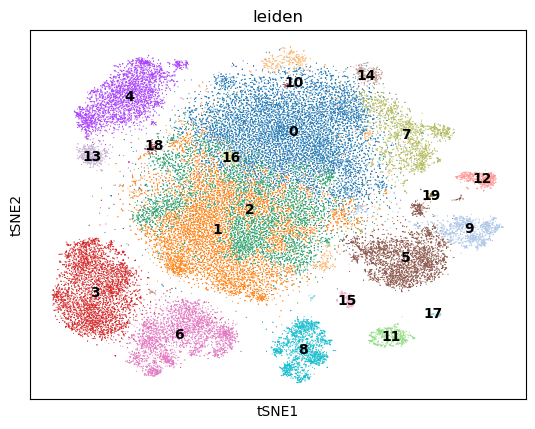

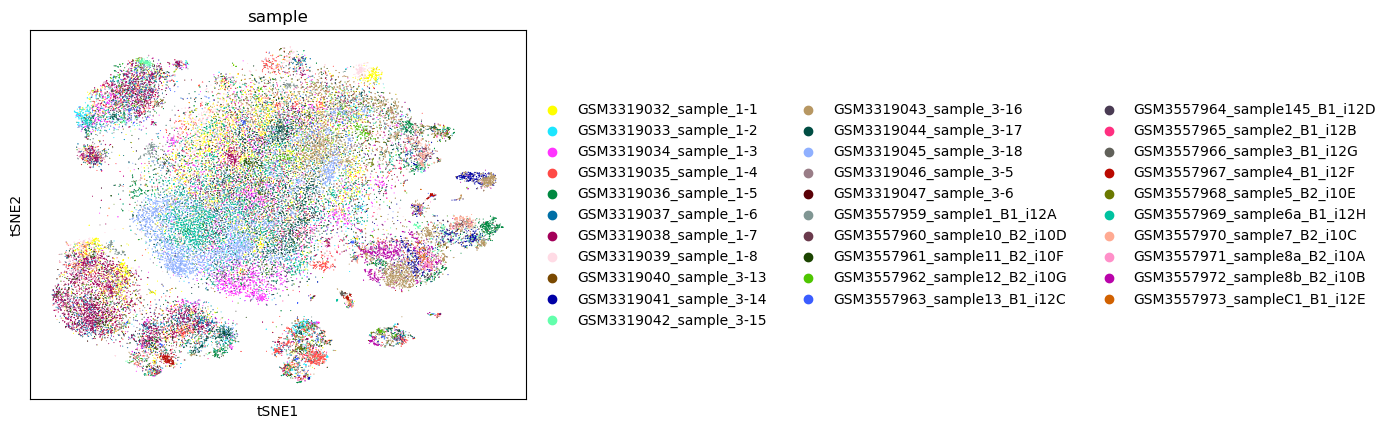

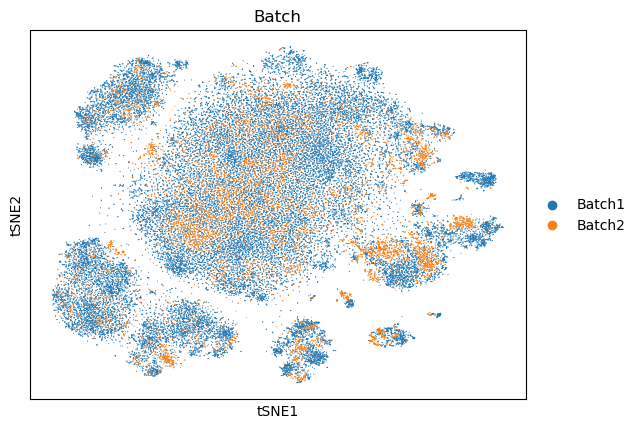

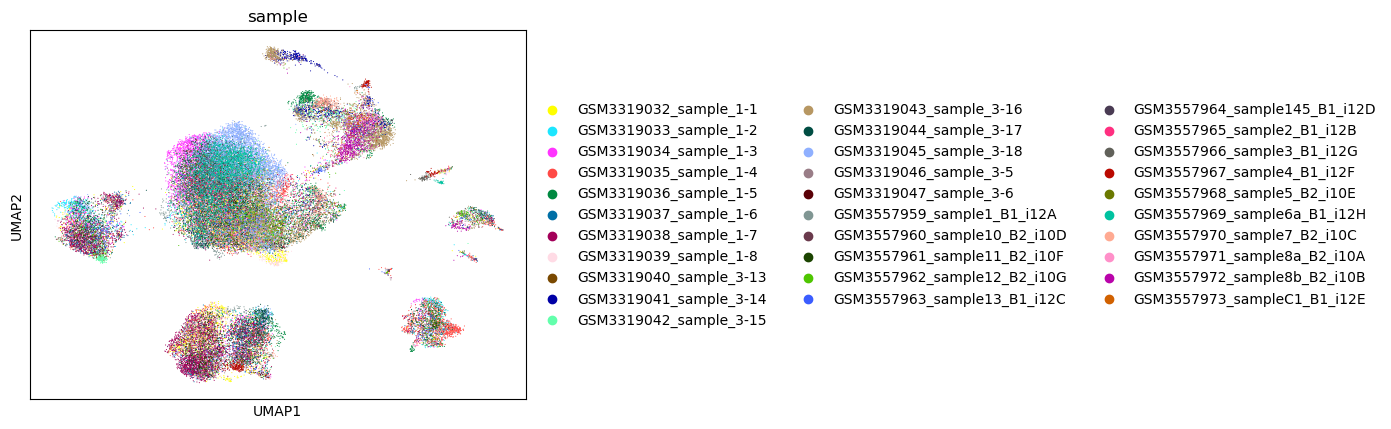

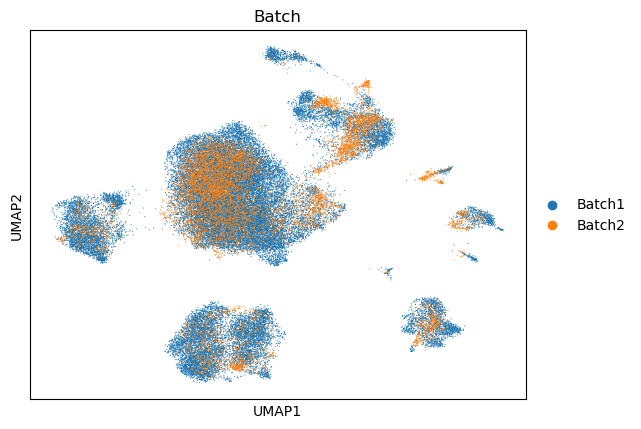

In [18]:
sc.pl.tsne(adata_scvi,color=["leiden"],legend_loc="on data")
sc.pl.tsne(adata_scvi,color=["sample"],legend_loc="right margin")
sc.pl.tsne(adata_scvi,color=["Batch"],legend_loc="right margin")
sc.pl.umap(adata_scvi,color=["sample"],wspace = 0.4)
sc.pl.umap(adata_scvi,color=["Batch"],wspace = 0.4)


In [19]:
# import os
# output_path = os.path.join(base_dir,"ovary_scvi_latent_umap_leiden.h5ad")
# adata_scvi.write(output_path,compression = 'gzip')

In [20]:
# adata_scvi.write("/home/qian@vitra.bio/ava/data/GSE118127/ovary_scvi_latent_umap_leiden.h5ad", compression="gzip")

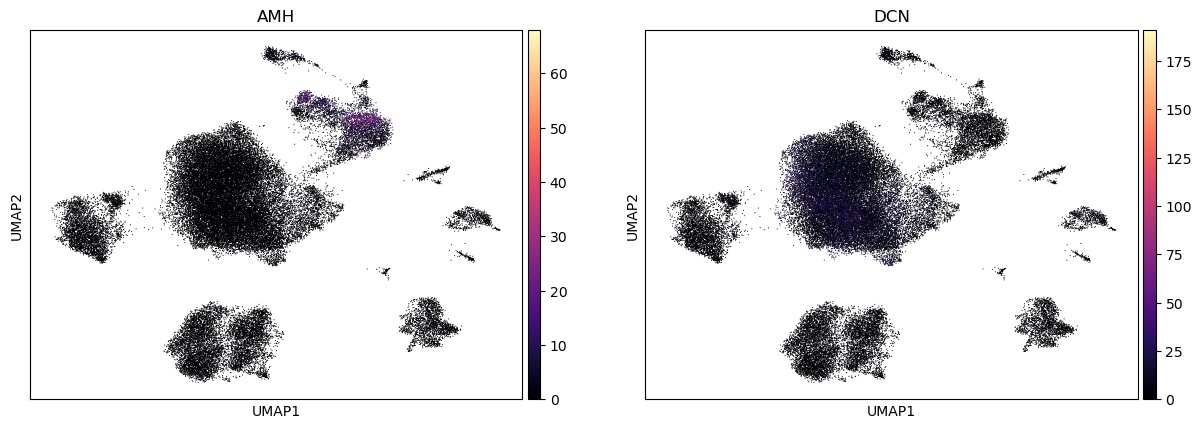

In [21]:
sc.pl.umap(adata_scvi, color=["AMH", "DCN"], layer=None, color_map="magma")

In [22]:
# 
denoised = model.get_normalized_expression(adata_scvi, library_size=1e4)
# 
adata_scvi.layers["scvi_norm"] = denoised.values


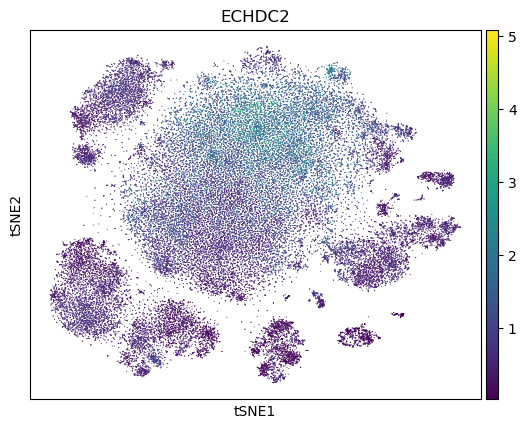

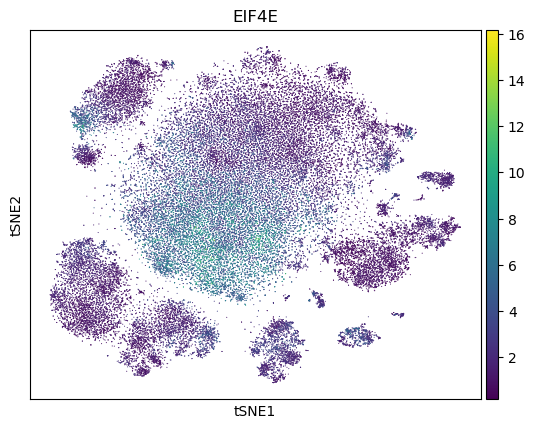

In [23]:
# 
sc.pl.tsne(adata_scvi, color=["ECHDC2"], layer="scvi_norm")
# 
sc.pl.tsne(adata_scvi, color=["EIF4E"], layer="scvi_norm")

In [24]:
adata_scvi.obs["sample"]
ref_batch = adata_scvi.obs["sample"].astype("category").cat.categories[0] 
ref_batch

'GSM3319032_sample_1-1'

In [25]:
denoised_ref = model.get_normalized_expression(
    adata_scvi,
    library_size=1e4,
    transform_batch=ref_batch,   
)
adata_scvi.layers["scvi_ref"] = denoised_ref.values

In [26]:
all_batches = adata_scvi.obs["sample"].astype("category").cat.categories.tolist()
denoised_avg = model.get_normalized_expression(
    adata_scvi,
    library_size=1e4,
    transform_batch=all_batches,   
)
adata_scvi.layers["scvi_ref"] = denoised_avg.values

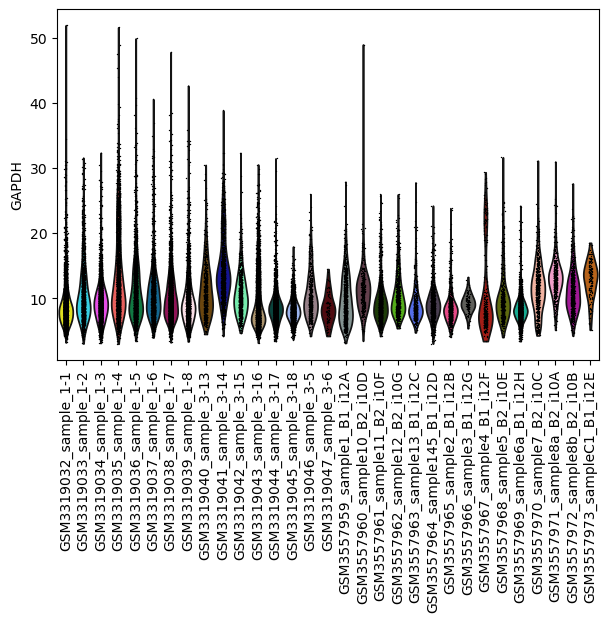

In [27]:
sc.pl.violin(
    adata_scvi,
    keys=["GAPDH"],
    groupby="sample",
    layer="scvi_ref",
    rotation=90
)

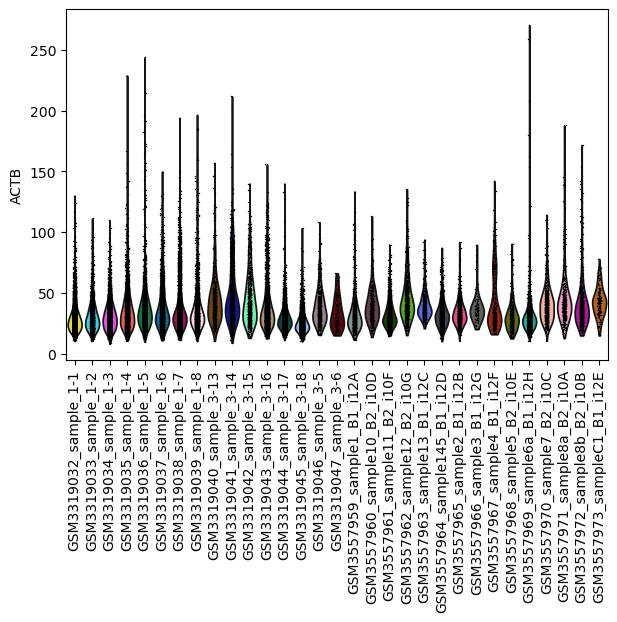

In [28]:
sc.pl.violin(
    adata_scvi,
    keys=["ACTB"],
    groupby="sample",
    layer="scvi_ref",
    rotation=90,
    multi_panel=True
)

# check house keeping gene's expression before batch effect removal

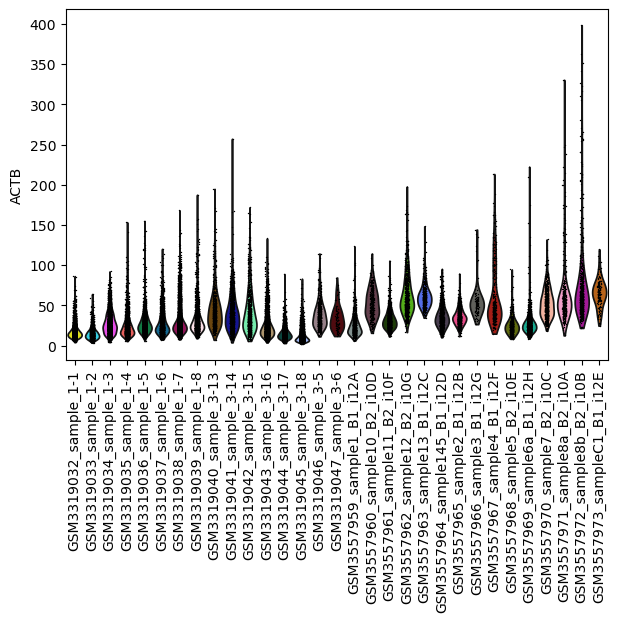

In [29]:
sc.pl.violin(
    adata_scvi,
    keys=["ACTB"],
    groupby="sample",
    layer="scvi_norm", 
    rotation=90
)

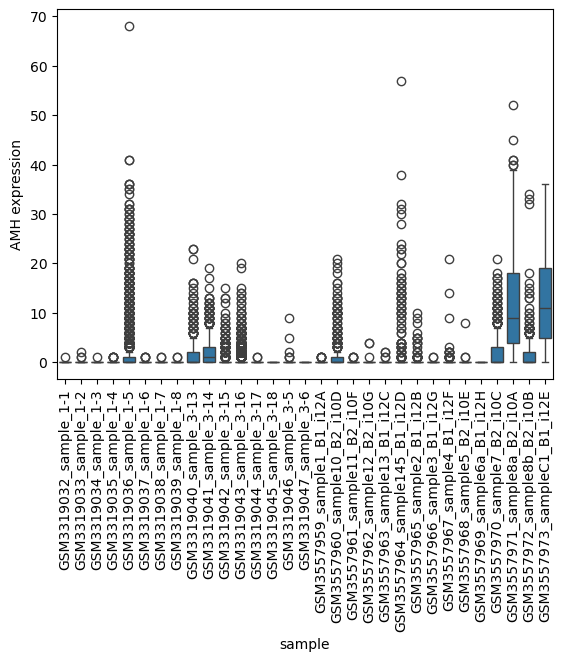

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x="sample", y=adata_all[:, "AMH"].X.toarray().flatten(), data=adata_all.obs)
plt.xticks(rotation=90)
plt.ylabel("AMH expression")
plt.show()

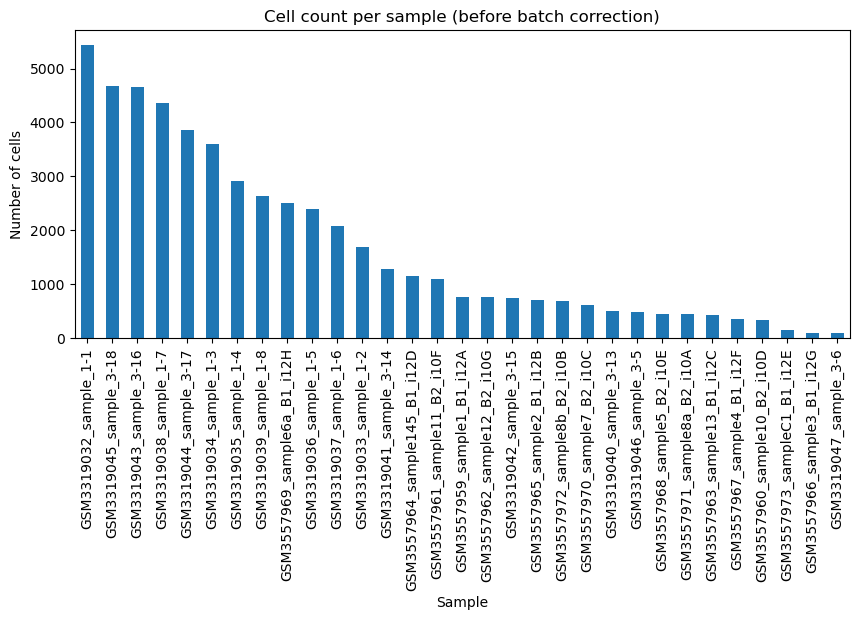

In [31]:
import matplotlib.pyplot as plt

# count # of cell per sample 
cell_counts = adata_all.obs["sample"].value_counts()

# bar plot
plt.figure(figsize=(10,4))
cell_counts.plot(kind="bar")
plt.ylabel("Number of cells")
plt.xlabel("Sample")
plt.title("Cell count per sample (before batch correction)")
plt.show()

In [32]:
de_all = model.differential_expression(
    adata_scvi,
    groupby="leiden",      
    delta=0.5,             
    batch_correction=True  
)

DE...: 100%|██████████| 20/20 [27:13<00:00, 81.65s/it]


In [33]:
de_all

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
RP11-864I4-1,0.928271,0.071729,2.560427,2.760762e-07,7.192850e-08,0.000459,0.000122,0.000459,0.000122,0.001832,0.000788,0 vs Rest,0,Rest
ECHDC2,0.927469,0.072531,2.548452,1.472519e-04,6.425918e-05,0.254772,0.109475,0.213932,0.098977,1.414178,0.545118,0 vs Rest,0,Rest
AC004160,0.920457,0.079543,2.448570,3.395944e-07,7.005615e-08,0.000826,0.000171,0.000826,0.000171,0.004530,0.001230,0 vs Rest,0,Rest
RP11-525K10,0.919255,0.080745,2.432263,6.132561e-07,1.292605e-07,0.000826,0.000171,0.000826,0.000171,0.004932,0.000767,0 vs Rest,0,Rest
LINC01140,0.915448,0.084552,2.382044,4.983107e-06,1.387794e-06,0.008076,0.002364,0.007985,0.002339,0.043074,0.010785,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTD-3203P2-1,0.027650,0.972350,-3.560098,1.415846e-07,3.134792e-06,0.000000,0.005826,0.000000,0.005691,0.000000,0.026852,19 vs Rest,19,Rest
IL1RAP,0.025245,0.974755,-3.653540,2.358465e-07,3.259008e-06,0.000000,0.005903,0.000000,0.005826,0.000000,0.030239,19 vs Rest,19,Rest
CYP1B1,0.024845,0.975155,-3.669951,4.321373e-06,7.833789e-05,0.000000,0.152580,0.000000,0.090188,0.000000,0.757984,19 vs Rest,19,Rest
GRASP,0.015628,0.984372,-4.142931,6.182219e-07,7.976398e-06,0.000000,0.013678,0.000000,0.013292,0.000000,0.079214,19 vs Rest,19,Rest


In [34]:
print(de_all.columns.tolist())

['proba_m1', 'proba_m2', 'bayes_factor', 'scale1', 'scale2', 'raw_mean1', 'raw_mean2', 'non_zeros_proportion1', 'non_zeros_proportion2', 'raw_normalized_mean1', 'raw_normalized_mean2', 'comparison', 'group1', 'group2']


-8.51514128999303 8.51514128999301


<Axes: >

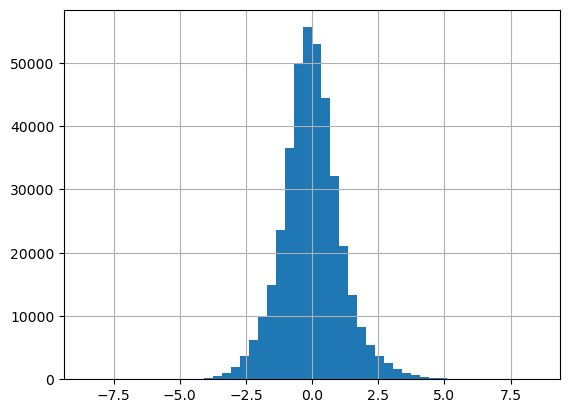

In [35]:
print(de_all["bayes_factor"].min(), de_all["bayes_factor"].max())

de_all["bayes_factor"].hist(bins=50)


In [36]:
# get marker for top 50
markers_0 = (
    de_all.query("comparison == '1 vs Rest' and proba_m1 > 0.9 and bayes_factor > 2")
           .sort_values("bayes_factor", ascending=False)
           .head(20)
)


In [37]:
markers_0

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2


# getting top 50 marker genes for each cluster

In [38]:
def get_scvi_top_markers(de_all,topN = 50, proba_thres = 0.9,bf_thres = 2.0):
    clusters = [c for c in de_all["group1"].astype(str).unique() if c != 'Rest']
    out = []
    for c in clusters:
        df = de_all[(de_all["group1"].astype(str)==c) & (de_all["group2"]=="Rest")]
        if "gene" not in df.columns:
            df = df.assign(gene = df.index)
        df = df[(df["proba_m1"] > proba_thres) & (df["bayes_factor"] > bf_thres)]
        df = df.sort_values("bayes_factor", ascending = False).head(topN).copy()
        df.insert(0,"cluster",c)
        out.append(df)
    return pd.concat(out,ignore_index=True) if out else pd.DataFrame()

In [39]:
top50 = get_scvi_top_markers(de_all,topN = 50, proba_thres = 0.9,bf_thres = 2.0)

In [40]:
top50

,cluster,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2,gene
0,0,0.928271,0.071729,2.560427,2.760762e-07,7.192850e-08,0.000459,0.000122,0.000459,0.000122,0.001832,0.000788,0 vs Rest,0,Rest,RP11-864I4-1
1,0,0.927469,0.072531,2.548452,1.472519e-04,6.425918e-05,0.254772,0.109475,0.213932,0.098977,1.414178,0.545118,0 vs Rest,0,Rest,ECHDC2
2,0,0.920457,0.079543,2.448570,3.395944e-07,7.005615e-08,0.000826,0.000171,0.000826,0.000171,0.004530,0.001230,0 vs Rest,0,Rest,AC004160
3,0,0.919255,0.080745,2.432263,6.132561e-07,1.292605e-07,0.000826,0.000171,0.000826,0.000171,0.004932,0.000767,0 vs Rest,0,Rest,RP11-525K10
4,0,0.915448,0.084552,2.382044,4.983107e-06,1.387794e-06,0.008076,0.002364,0.007985,0.002339,0.043074,0.010785,0 vs Rest,0,Rest,LINC01140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,19,0.986576,0.013424,4.297183,1.174832e-04,4.848534e-05,0.030000,0.080157,0.030000,0.074388,0.366524,0.381335,19 vs Rest,19,Rest,SEC23A
810,19,0.986576,0.013424,4.297183,6.348755e-05,9.968999e-06,0.090000,0.019716,0.090000,0.018925,1.243690,0.080755,19 vs Rest,19,Rest,TUBG1
811,19,0.986375,0.013625,4.282165,1.483607e-04,5.013905e-05,0.160000,0.101975,0.150000,0.088819,2.043487,0.436838,19 vs Rest,19,Rest,PSMD14
812,19,0.986375,0.013625,4.282165,1.669759e-04,5.884317e-05,0.140000,0.100258,0.120000,0.089378,2.064101,0.440775,19 vs Rest,19,Rest,NDUFS3


In [41]:
top50.to_csv("/home/qian@vitra.bio/ava/data/GSE118127/top50_markers.csv",index=False)